In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Reproducing the DRW Parameter Distributions for the SDSS S82 AGN

__Author:__ Ji Won Park (@jiwoncpark) <br>
__Created:__ 08/08/2019 <br>
__Last run:__ 10/30/2019 <br>
__Goals:__
- Reproduce the plots in [MacLeod et al 2010](https://iopscience.iop.org/article/10.1088/0004-637X/721/2/1014) describing the dependence of the damped random walk (DRW) parameters on physical properties
- Confirm that my plotting code is consistent with that used by MacLeod et al 2010, so that it could be used to validate the DC2 AGN (see separate notebook: `Validate_DC2_DRW.ipynb`)

### About the data

MacLeod et al have published the data used in their 2010 modeling of AGN variability as a DRW [here](http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html). The page also has a detailed description of the schema. We'll first read in two of their data files summarizing the AGN light curves:
- `s82drw_<bandpass>.dat` contain the DRW parameters (called `drw` in the code)
- `DB_QSO_S82.dat` contains the black hole properties from the [Shen et al 2008](https://iopscience.iop.org/article/10.1086/587475) catalog for the same AGN (called `shen` in the code)

If you are working locally, download the data using the below instructions and change the paths `drw_path` and `shen_path` accordingly. If you're on the NERSC Jupyter environment, you don't have to do anything, as the datasets have been prefetched to my `cscratch1` space.

### Downloading the data

You can get them by running:
```bash
wget http://faculty.washington.edu/ivezic/macleod/qso_dr7/s82drw.tar.gz
tar -xvzf s8drw.tar.gz
wget http://faculty.washington.edu/ivezic/macleod/qso_dr7/DB_QSO_S82.dat.gz
gunzip DB_QSO_S82.dat.gz
```

In [2]:
# Paths to the data files, modify for your system
drw_path = '/global/cscratch1/sd/jwp/agn_validation/sdss_s82_agn_data/s82drw_{:s}.dat'
shen_path = '/global/cscratch1/sd/jwp/agn_validation/sdss_s82_agn_data/DB_QSO_S82.dat'

In [3]:
# Define global quantities

# Normalizing wavelength
wavelength_norm = 4000.0 # in angstroms
# Central wavelength (value) for each SDSS bandpass (key) used to estimate the rest-frame wavelength
wavelength_center = {'u': 3520.0, 'g': 4800.0, 'r': 6250.0, 'i': 7690.0, 'z': 9110.0} # iM_i_kcorr_xn angstroms
# Color (value) for each SDSS bandpass (key) used for plotting
color_dict = {'u': 'magenta', 'g': 'blue', 'r': 'green', 'i': 'orange', 'z': 'red'}

In [4]:
# Read DRW parameter data files, `s82drw_<bandpass>.dat`


drw_columns = ['SDR5ID', 'ra', 'dec', 'redshift', 'M_i', 'log_mass_BH', 'chi2',
               'log_tau', 'log_sighat', 'log_tau_lowlim', 'log_tau_uplim', 'log_sfhat_lowlim', 'log_sfhat_uplim',
               'edge', 'll_model', 'll_noise', 'll_inf', 'mu', 'N_obs'] # taken from schema page

# Dictionary of pandas dataframes, each dataframe representing the band
drw_dict = {} 
for bp in 'ugriz':
    drw_bp = pd.read_csv(drw_path.format(bp), index_col=False, sep='\s+', skiprows=3, names=drw_columns)
    # z correction
    z_corr = 1.0/(1.0 + drw_bp['redshift'].values)
    # normalized rest-frame wavelength
    drw_bp['rf_wavelength'] = wavelength_center[bp]*z_corr/wavelength_norm 
    drw_bp['log_rf_wavelength'] = np.log10(drw_bp['rf_wavelength'].values)
    # log of rest-frame tau in days
    drw_bp['log_rf_tau'] = drw_bp['log_tau'].values - np.log10(1.0 + drw_bp['redshift'].values)
    # log of SF_inf in mag (with the proper unit conversion, see Note (4) in schema)
    drw_bp['log_sf_inf'] = drw_bp['log_sighat'].values + 0.5*drw_bp['log_rf_tau'] - 0.5*np.log10(365.0)
    drw_bp['bandpass'] = bp
    drw_bp['id'] = np.arange(len(drw_bp)) # can't use SDR5ID b/c collapses new QSOs as -1 (not unique)
    drw_dict[bp] = drw_bp

# Concatenate across bands
drw_all = pd.concat(drw_dict.values(), axis=0) 

In [5]:
# Read Shen data file, `DB_QSO_S82.dat`

shen_columns = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_kcorr2', 'redshift', 'mass_BH', 'Lbol', 
                'u', 'g', 'r', 'i', 'z', 'Au']

shen = pd.read_csv(shen_path, index_col=False, sep='\s+', skiprows=2, names=shen_columns)

We will need the `drw` catalog for the DRW fit parameters and the `shen` catalog for the black hole properties so we merge the two for convenience.

In [6]:
merged = drw_all.merge(shen, on=['ra', 'dec'], how='inner', suffixes=('', '_shen'))
merged.columns.values

array(['SDR5ID', 'ra', 'dec', 'redshift', 'M_i', 'log_mass_BH', 'chi2',
       'log_tau', 'log_sighat', 'log_tau_lowlim', 'log_tau_uplim',
       'log_sfhat_lowlim', 'log_sfhat_uplim', 'edge', 'll_model',
       'll_noise', 'll_inf', 'mu', 'N_obs', 'rf_wavelength',
       'log_rf_wavelength', 'log_rf_tau', 'log_sf_inf', 'bandpass', 'id',
       'dbID', 'SDR5ID_shen', 'M_i_shen', 'M_i_kcorr2', 'redshift_shen',
       'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au'], dtype=object)

Let's check if the K-corrected (z=0) i-band absolute magnitudes and the redshifts in the `s82_drw_*.dat` catalog and the `DB_QSO_S82.dat` (Shen et al 2008) catalog are consistent.

In [7]:
np.testing.assert_array_almost_equal(merged['M_i'].values, merged['M_i_shen'].values)
np.testing.assert_array_almost_equal(merged['redshift'].values, merged['redshift_shen'].values)

It turns out we can use either our own `id` column or Shen's `dbID` column as unique QSO identifiers. There are 9258 unique QSOs.

In [8]:
print(merged['id'].nunique(), merged['dbID'].nunique())

9258 9258


### Note on the dataset size

The paper says there are 9275 AGN, but the dataset only contains 9258. This is because 17 of the quasars had been demoted between the time of the publication and the time of the DR7 release. Details of this revision are [here](http://faculty.washington.edu/ivezic/macleod/qso_dr7/revisions.html).

In [9]:
for bp, bp_drw in drw_dict.items():
    print(bp, bp_drw.shape)

u (9258, 25)
g (9258, 25)
r (9258, 25)
i (9258, 25)
z (9258, 25)


### Selections

MacLeod et al applies three rounds of selection, which enforce the following criteria:
1. $N_{obs} >= 10$ (remove ones with too-few observations)
2. $ln \left( \frac{L_{model}}{L_{noise}} \right) > 2$ where $L_{model}$, $L_{noise}$ are model and noise likelihoods, respectively (remove ones better explained by uncorrelated noise than the model, i.e. too-noisy light curves)
3. $ln \left( \frac{L_{model}}{L_{\infty}} \right) > 0.05$ where $L_\infty$ is the likelihood that $\tau \rightarrow \infty$ (remove ones with light curves so short that the fitted $\tau$ is a lower limit)

In [10]:
# Apply selection

before_cut = len(merged)
print("Before selection: ", before_cut)
## 1.
#merged = merged.query('(log_tau != -10.0) & (log_sighat != -10.0)') # same result as below
merged = merged.query('N_obs >= 10')
after_1 = len(merged)
print("After Selection 1: ", after_1)
print("removed ", before_cut - after_1)
# 2.
merged['del_noise'] = merged['ll_model'] - merged['ll_noise']
merged = merged.query('del_noise > 2.0')
after_2 = len(merged)
print("After Selection 2: ", after_2)
print("removed ", after_1 - after_2)
# 3.
merged['del_inf'] = merged['ll_model'] - merged['ll_inf']
merged = merged.query('del_inf > 0.05')
after_3 = len(merged)
print("After Selection 3: ", after_3)
print("removed ", after_2 - after_3)

Before selection:  46290
After Selection 1:  45735
removed  555
After Selection 2:  42580
removed  3155
After Selection 3:  33238
removed  9342


As suggested in Note (5) in the [schema description](http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_drw.html), we'll also remove AGN on the edge of grid or too close to the edge for a proper centroid peak estimation.

In [11]:
merged = merged.query('edge == 0')
after_edgecut = len(merged)
print("After edge cut: ", after_edgecut)
print("removed ", after_3 - after_edgecut)

After edge cut:  33236
removed  2


As `SF_inf` is very sensitive to the magnitude selection, we will need to match the r-band distribution with the S82 data if we ever want to compare another dataset with S82.

In [12]:
selected = merged[(merged['i'] < 20.5) & (merged['redshift'] < 3.11)].copy()

In [13]:
area = 290 # sq deg

Text(0.5, 0, 'S82 r (mag)')

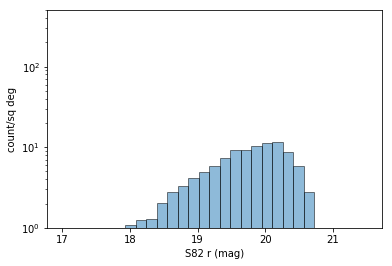

In [14]:
bins=np.linspace(17, 21.5, 30)
#_ = plt.hist(merged['r'].values, weights=np.ones_like(merged['r'].values)/area, bins=bins, edgecolor='k', label='before i < 20.5', alpha=0.5)
_ = plt.hist(selected['r'].values, weights=np.ones_like(selected['r'].values)/area, bins=bins, edgecolor='k', label='after i < 20.5', alpha=0.5)

plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("S82 r (mag)")
#plt.legend()

Text(0.5, 0, 'S82 i (mag)')

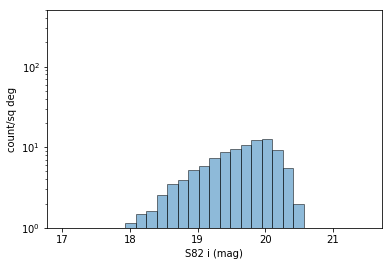

In [15]:
bins=np.linspace(17, 21.5, 30)
#_ = plt.hist(merged['i'].values, weights=np.ones_like(merged['r'].values)/area, bins=bins, edgecolor='k', label='before i < 20.5', alpha=0.5)
_ = plt.hist(selected['i'].values, weights=np.ones_like(selected['r'].values)/area, bins=bins, edgecolor='k', label='after i < 20.5', alpha=0.5)
#_ = plt.hist(selected.loc[selected['duty_cycle']==True]['r'].values, weights=np.ones_like(selected.loc[selected['duty_cycle']==True]['r'].values)/area, bins=bins, edgecolor='k', label='duty cycle on', alpha=0.5)

plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("S82 i (mag)")
#plt.legend()

Text(0.5, 0, 'S82 i (mag)')

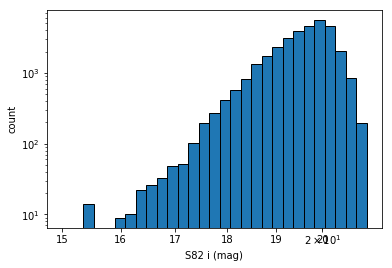

In [16]:
_ = plt.hist(merged['i'].values, bins=10**np.linspace(np.log10(15), np.log10(21), 30), edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.gca().set_xscale('log')
plt.gca().set_xticks(np.arange(15, 21, 1))
plt.gca().set_xticklabels(np.arange(15, 21, 1))
plt.ylabel("count")
plt.xlabel("S82 i (mag)")

Text(0.5, 0, 'S82 u (mag)')

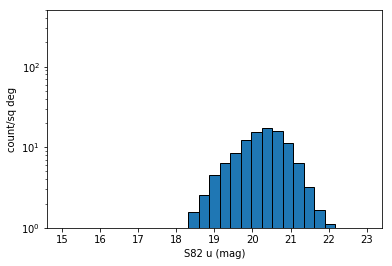

In [17]:
_ = plt.hist(merged['u'].values, weights=np.ones_like(merged['r'].values)/area, bins=np.linspace(15, 23, 30), edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("S82 u (mag)")

M_i brightest: -29.563000


Text(0.5, 0, 'M_i (mag)')

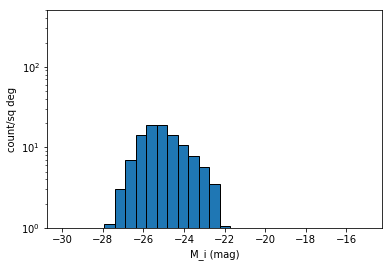

In [18]:
_, binning, _ = plt.hist(selected['M_i'].values, weights=np.ones_like(selected['r'].values)/area, bins=np.linspace(-30, -15, 30), edgecolor='k')
print("M_i brightest: {:f}".format(merged['M_i'].values.min()))
plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("M_i (mag)")

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


Text(0.5, 0, 'S82 redshift')

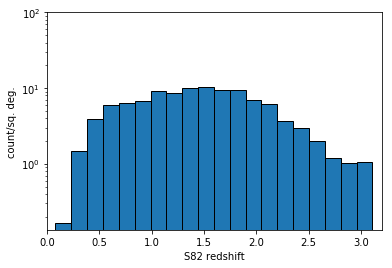

In [19]:
plt.hist(selected['redshift'], weights=np.ones(selected.shape[0])/area, 
         bins=20,
         edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.ylim([0, 100])
plt.xlim([0, 3.2])
plt.ylabel('count/sq. deg.')
plt.xlabel('S82 redshift')

## Distribution of rest-frame $\tau$

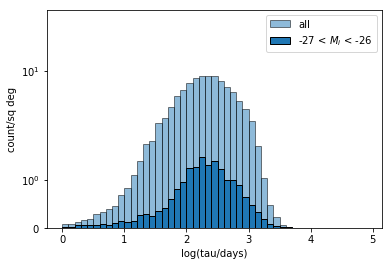

In [20]:
plotting_utils.plot_fig3_topleft(selected, area, False)

## Distribution of $SF_{\infty}$

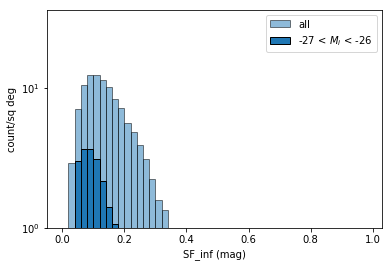

In [21]:
plotting_utils.plot_fig3_topright(selected, area, False)

## $\log \tau$ vs. $\log SF_\infty$

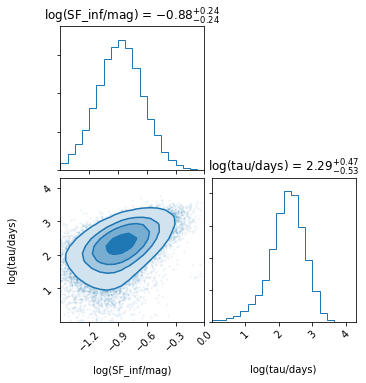

In [22]:
plotting_utils.plot_fig3_bottom(selected, bandpass=None, duty_cycle_on=False)

## Dependence on rest-frame wavelength

As done in the paper, we query AGN that have been observed in at least two filters to explore the trends of the DRW parameters with rest-frame wavelength.

In [23]:
# Get QSOs observed in at least two filters
from collections import Counter

counts = Counter(selected.id)
lam_fit = selected[selected.id.isin([key for key in counts if counts[key] >= 2])].copy()

The paper says the query leaves around 8000 AGN.

In [24]:
lam_fit['id'].nunique()

7153

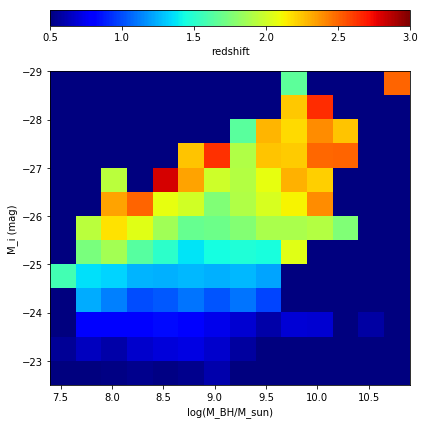

In [25]:
# Fig 12 top left
plotting_utils.plot_2d_hist_stats(lam_fit, 
                   colnames_2d=['mass_BH', 'M_i'],
                   bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29, -22.0, 0.5)],
                   invert_y_axis=True,
                   colname_color='redshift',
                   ticks_color=np.arange(0.5, 3.2, 0.5),
                   invert_color=False,
                   x_label='log(M_BH/M_sun)',
                   y_label='M_i (mag)',
                   color_label='redshift',
                   cmap_name='jet')

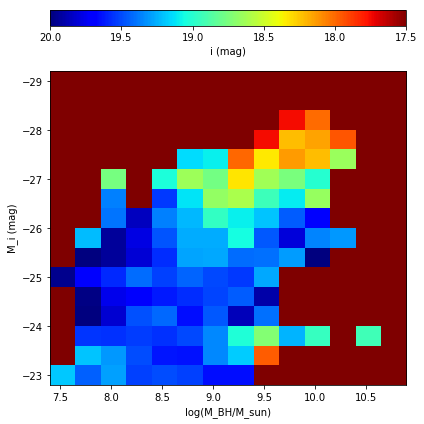

In [26]:
# Fig 12 top right
plotting_utils.plot_2d_hist_stats(lam_fit, 
                           colnames_2d=['mass_BH', 'M_i'],
                           bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                           invert_y_axis=True,
                           colname_color='i',
                           ticks_color=np.arange(17.5, 20.5, 0.5),
                           invert_color=True,
                           x_label='log(M_BH/M_sun)',
                           y_label='M_i (mag)',
                           color_label='i (mag)',
                           cmap_name='jet_r')

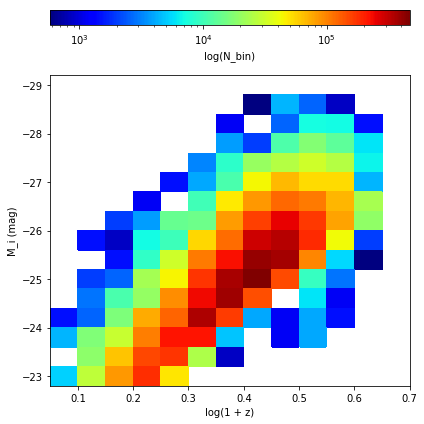

In [27]:
# Fig 12 bottom left
x = np.log10(lam_fit['redshift'].values + 1.0)
y = lam_fit['M_i'].values
x_bins = np.arange(0.05, 0.75, 0.05)
y_bins = np.arange(-29.2, -22.5, 0.4)

plotting_utils.plot_2d_hist(x, y, x_bins, y_bins,
                   invert_y_axis=True,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(1 + z)',
                   y_label='M_i (mag)',
                   color_label='log(N_bin)',
                   cmap_name='jet',
                           weight=1.0/area)

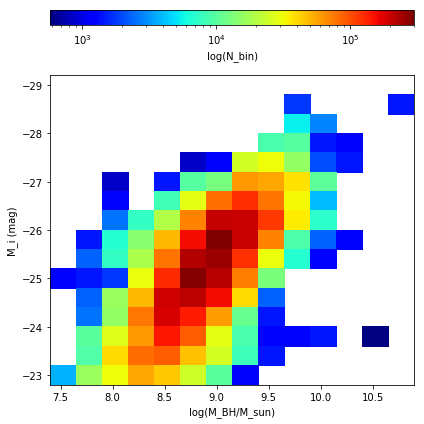

In [28]:
# Fig 12 bottom right
x = lam_fit['mass_BH'].values
y = lam_fit['M_i'].values
x_bins = np.arange(7.4, 11.0, 0.25)
y_bins = np.arange(-29.2, -22.5, 0.4)

plotting_utils.plot_2d_hist(x, y, x_bins, y_bins,
                   invert_y_axis=True,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(M_BH/M_sun)',
                   y_label='M_i (mag)',
                   color_label='log(N_bin)',
                   cmap_name='jet',
                           weight=1.0/area)

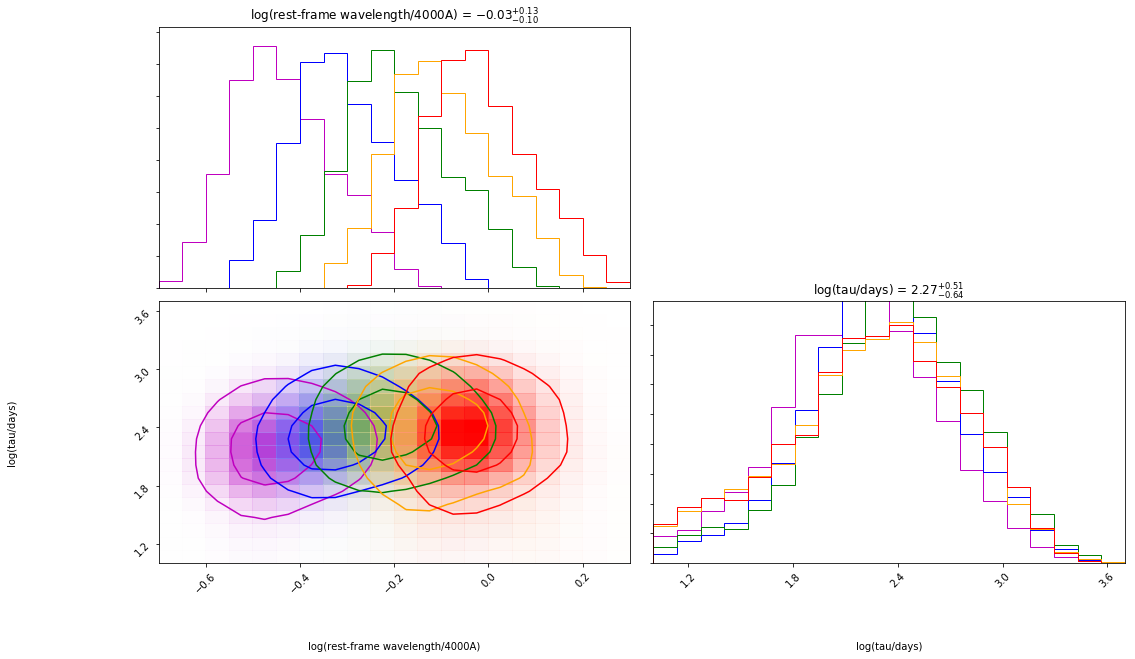

In [29]:
# Fig 13 top
plotting_utils.plot_fig13(lam_fit, 'log_rf_tau', [1, 3.7], 'log(tau/days)')

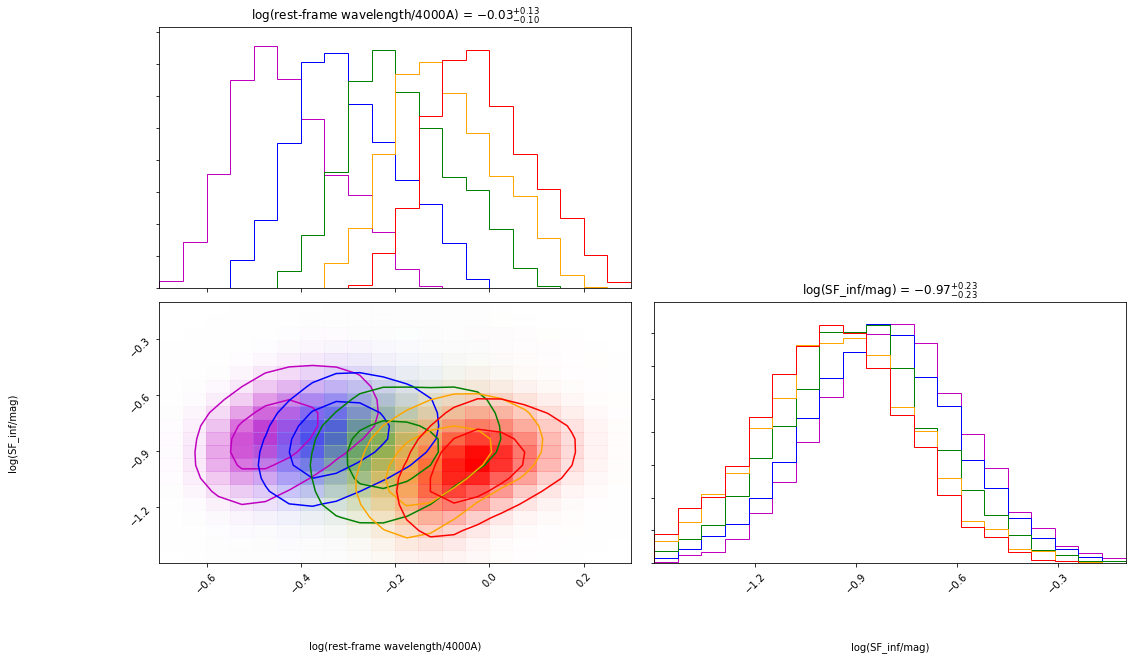

In [30]:
# Fig 13 bottom
plotting_utils.plot_fig13(lam_fit, 'log_sf_inf', [-1.5, -0.1], 'log(SF_inf/mag)')

## Dependence on luminosity, redshift, and black hole mass

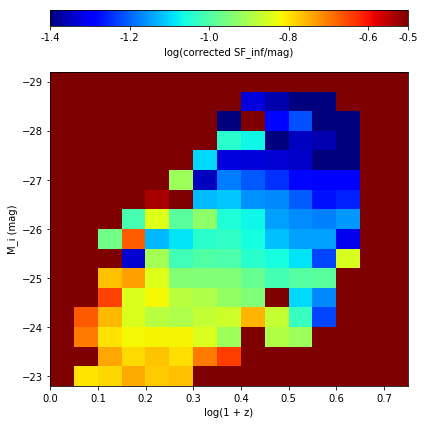

In [31]:
# Fig 14 top left
B_sf_inf = -0.479
lam_fit['log_z_corr_inv'] = np.log10(1.0 + lam_fit['redshift'].values)
lam_fit['log_sf_inf_corrected'] = lam_fit['log_sf_inf'].values - B_sf_inf*lam_fit['log_rf_wavelength'].values

plotting_utils.plot_2d_hist_stats(lam_fit,
                         colnames_2d=['log_z_corr_inv', 'M_i'],
                         bins_2d=[np.arange(0.0, 0.8, 0.05), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_sf_inf_corrected',
                         ticks_color=[-1.4, -1.2, -1.0, -0.8, -0.6, -0.5],
                         invert_color=False,
                         x_label='log(1 + z)',
                         y_label='M_i (mag)',
                         color_label='log(corrected SF_inf/mag)',
                         cmap_name='jet')

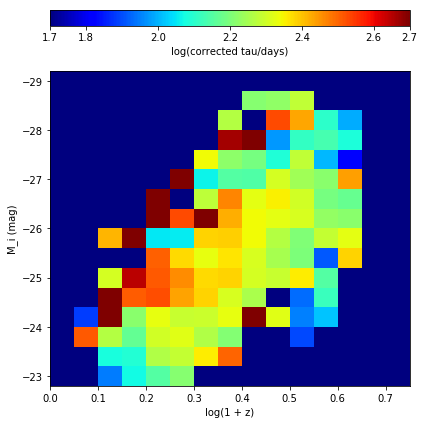

In [32]:
# Fig 14 top right
B_tau = 0.17
lam_fit['log_rf_tau_corrected'] = lam_fit['log_rf_tau'].values - B_tau*lam_fit['log_rf_wavelength'].values

plotting_utils.plot_2d_hist_stats(lam_fit,
                         colnames_2d=['log_z_corr_inv', 'M_i'],
                         bins_2d=[np.arange(0.0, 0.8, 0.05), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_rf_tau_corrected',
                         ticks_color=[1.7, 1.8, 2.0, 2.2, 2.4, 2.6, 2.7],
                         invert_color=False,
                         x_label='log(1 + z)',
                         y_label='M_i (mag)',
                         color_label='log(corrected tau/days)',
                         cmap_name='jet')

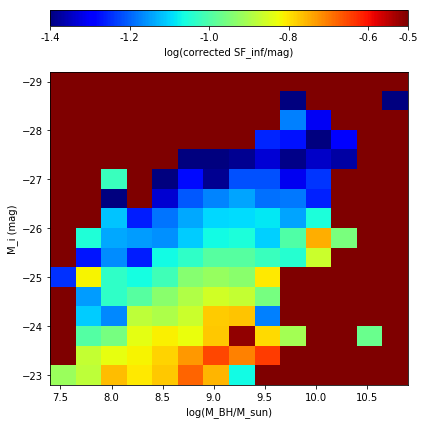

In [33]:
# Fig 14 bottom left
plotting_utils.plot_2d_hist_stats(lam_fit,
                         colnames_2d=['mass_BH', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_sf_inf_corrected',
                         ticks_color=[-1.4, -1.2, -1.0, -0.8, -0.6, -0.5],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(corrected SF_inf/mag)',
                         cmap_name='jet')

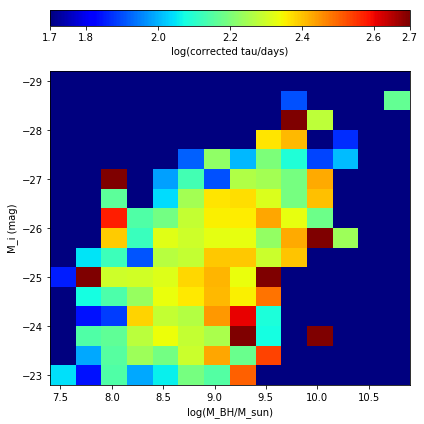

In [34]:
# Fig 14 bottom right
plotting_utils.plot_2d_hist_stats(lam_fit,
                         colnames_2d=['mass_BH', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_rf_tau_corrected',
                         ticks_color=[1.7, 1.8, 2.0, 2.2, 2.4, 2.6, 2.7],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(corrected tau/days)',
                         cmap_name='jet')

## Eddington ratio partly drives variability

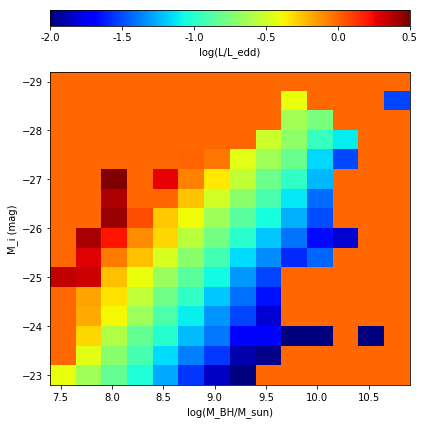

In [35]:
# Fig 15 left
log_L_edd = np.log10(1.5) + 38.0 + lam_fit['mass_BH'].values # approximation used by MacLeod et al 2010, in erg/s
lam_fit['log_edd_ratio'] = lam_fit['Lbol'].values - log_L_edd
plotting_utils.plot_2d_hist_stats(lam_fit,
                         colnames_2d=['mass_BH', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_edd_ratio',
                         ticks_color=[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(L/L_edd)',
                         cmap_name='jet')

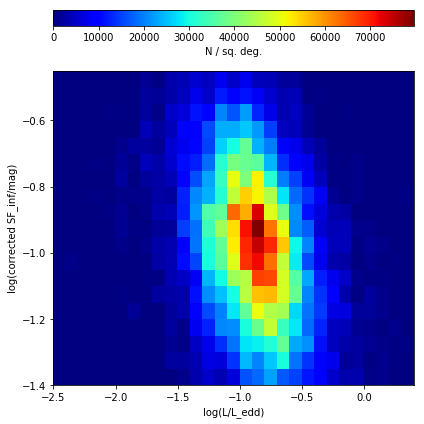

In [36]:
# Fig 15 right

plotting_utils.plot_2d_hist(lam_fit['log_edd_ratio'].values,
                   lam_fit['log_sf_inf_corrected'].values,
                   np.arange(-2.5, 0.5, 0.1),
                   np.arange(-1.4, -0.4, 0.05),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=False,
                   x_label='log(L/L_edd)', 
                   y_label='log(corrected SF_inf/mag)',
                   color_label='N / sq. deg.',
                   cmap_name='jet',
                           weight=1.0/area)

## Additional plots for comparison

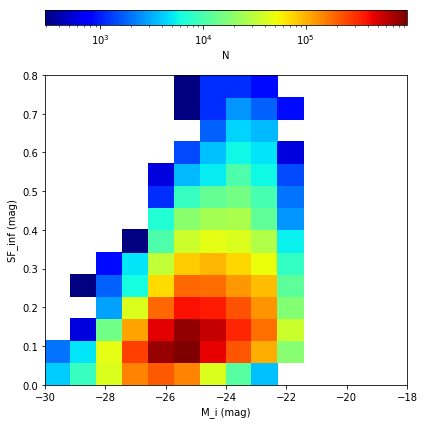

In [37]:
plotting_utils.plot_2d_hist(selected['M_i'].values,
                   10**selected['log_sf_inf'].values,
                   np.linspace(-30, -18, 15),
                   np.linspace(0.0, 0.8, 15),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='M_i (mag)', 
                   y_label='SF_inf (mag)',
                   color_label='N',
                   cmap_name='jet',
                           weight=1.0/area)

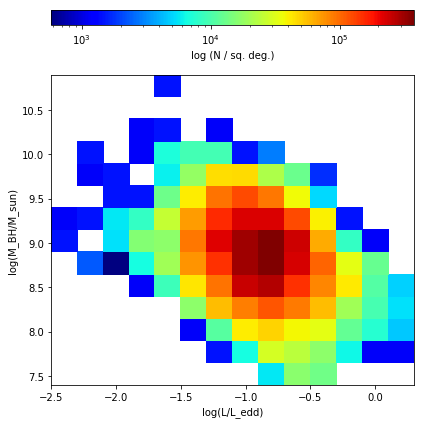

In [38]:
plotting_utils.plot_2d_hist(lam_fit['log_edd_ratio'].values,
                   lam_fit['mass_BH'].values,
                   np.arange(-2.5, 0.5, 0.2),
                   np.arange(7.4, 11.0, 0.25),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(L/L_edd)', 
                   y_label='log(M_BH/M_sun)',
                   color_label='log (N / sq. deg.)',
                   cmap_name='jet',
                           weight=1.0/area)

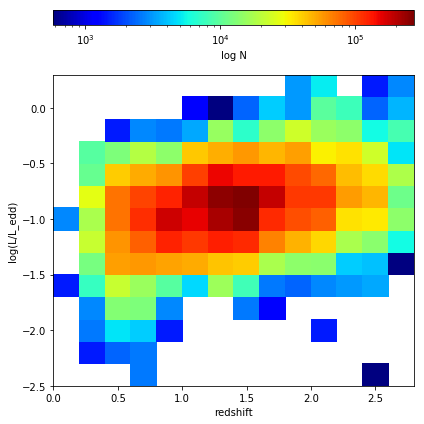

In [39]:
plotting_utils.plot_2d_hist(lam_fit['redshift'].values,
                   lam_fit['log_edd_ratio'].values,
                            np.arange(0.0, 3.0, 0.2),
                   np.arange(-2.5, 0.5, 0.2),
                  
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='redshift', 
                   y_label='log(L/L_edd)',
                   color_label='log N',
                   cmap_name='jet',
                            weight=1.0/area)

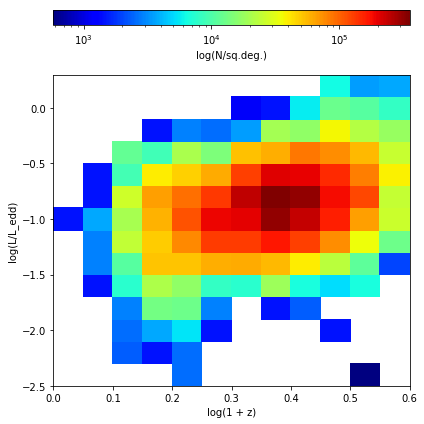

In [40]:
plotting_utils.plot_2d_hist(np.log10(1.0 + lam_fit['redshift'].values),
                   lam_fit['log_edd_ratio'].values,
                            np.arange(0.0, 0.62, 0.05),
                   np.arange(-2.5, 0.5, 0.2),
                  
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(1 + z)', 
                   y_label='log(L/L_edd)',
                   color_label='log(N/sq.deg.)',
                   cmap_name='jet',
                           weight=1.0/area)

## Likelihood of black hole mass

Text(0.5, 0, 'log(M_BH/M_sun)')

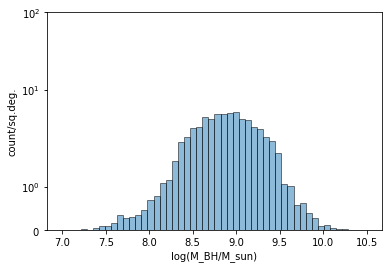

In [41]:
_, binning, _ = plt.hist(selected['mass_BH'].values,
                         weights=np.ones_like(selected['mass_BH'].values)/area,
                         bins=50, color='tab:blue', range=[7, 10.5], edgecolor='k', alpha=0.5)
plt.yscale('symlog')
plt.ylim([0, 100])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

Text(0.5, 0, 'log(M_BH/M_sun)')

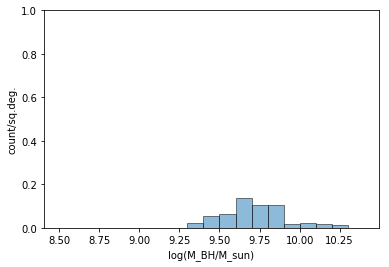

In [42]:
# Fig 16 top
_, binning, _ = plt.hist(selected[(selected['M_i'] > -28.5) & (selected['M_i'] < -27.5)]['mass_BH'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -28.5) & (selected['M_i'] < -27.5)]['mass_BH'].values)/area,
                         bins=np.arange(8.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 1])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

Text(0.5, 0, 'log(M_BH/M_sun)')

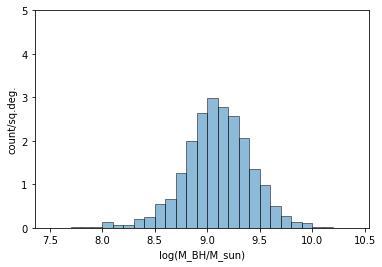

In [43]:
# Fig 16 second
_, binning, _ = plt.hist(selected[(selected['M_i'] > -26.5) & (selected['M_i'] < -25.5)]['mass_BH'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -26.5) & (selected['M_i'] < -25.5)]['mass_BH'].values)/area,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 5])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

In [44]:
np.log10(1 + 3.1)

0.6127838567197355

Text(0.5, 0, 'log(M_BH/M_sun)')

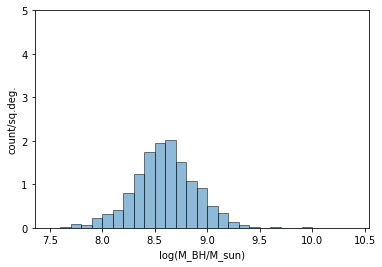

In [45]:
# Fig 16 third
_, binning, _ = plt.hist(selected[(selected['M_i'] > -24.5) & (selected['M_i'] < -23.5)]['mass_BH'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -24.5) & (selected['M_i'] < -23.5)]['mass_BH'].values)/area,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 5])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

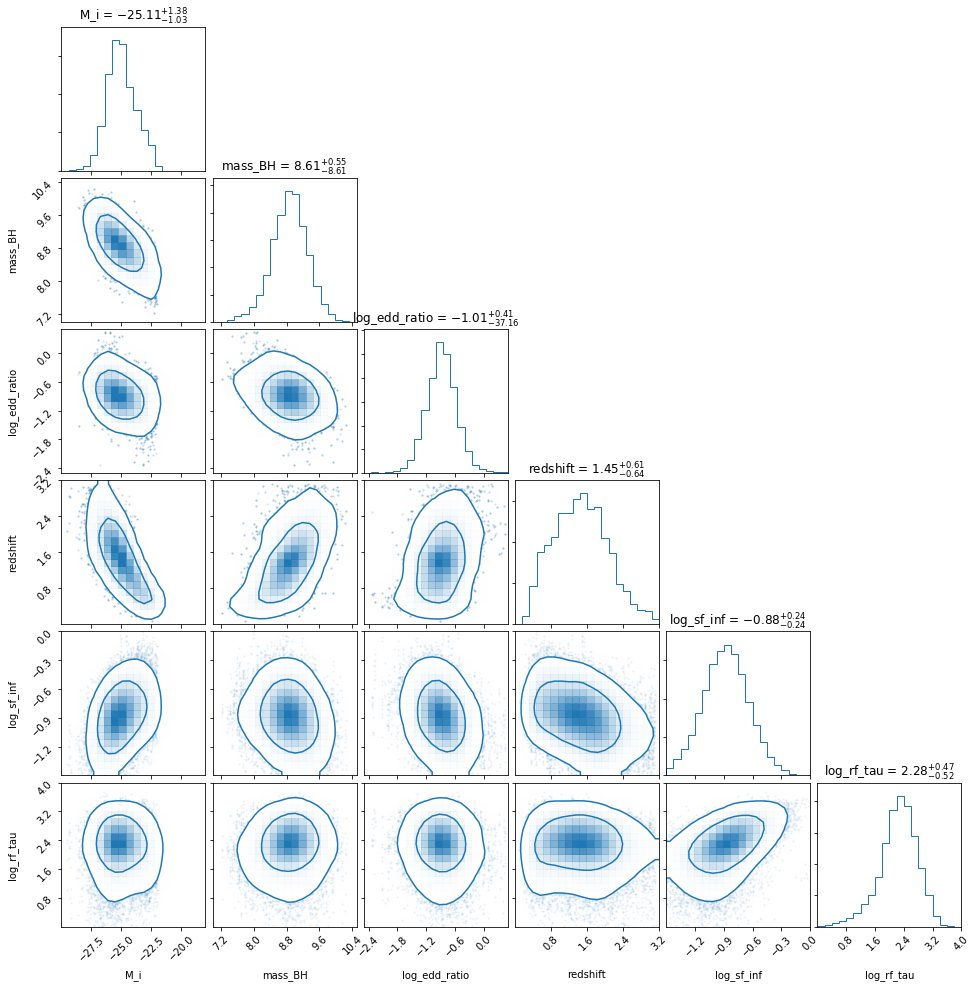

In [46]:
import corner

corner_cols = ['M_i', 'mass_BH', 'log_edd_ratio', 'redshift', 'log_sf_inf', 'log_rf_tau']
_ = corner.corner(lam_fit[corner_cols],
              color='tab:blue',
              smooth=1.0,
              labels=corner_cols,
              fill_contours=False,
              show_titles=True,
              levels=[0.68, 0.95],
              range=[[-30, -18], [7.0, 10.5], [-2.5, 0.5], [0, 3.2], [-1.5, 0], [0, 4]],
              hist_kwargs=dict(density=True))

In [47]:
lam_fit.columns

Index(['SDR5ID', 'ra', 'dec', 'redshift', 'M_i', 'log_mass_BH', 'chi2',
       'log_tau', 'log_sighat', 'log_tau_lowlim', 'log_tau_uplim',
       'log_sfhat_lowlim', 'log_sfhat_uplim', 'edge', 'll_model', 'll_noise',
       'll_inf', 'mu', 'N_obs', 'rf_wavelength', 'log_rf_wavelength',
       'log_rf_tau', 'log_sf_inf', 'bandpass', 'id', 'dbID', 'SDR5ID_shen',
       'M_i_shen', 'M_i_kcorr2', 'redshift_shen', 'mass_BH', 'Lbol', 'u', 'g',
       'r', 'i', 'z', 'Au', 'del_noise', 'del_inf', 'log_z_corr_inv',
       'log_sf_inf_corrected', 'log_rf_tau_corrected', 'log_edd_ratio'],
      dtype='object')